# Homework 2
此部分作业要求使用PCA技术对给定的人脸数据集进行处理
本次使用到的人脸数据集是 ORL人脸数据集，共包含40个不同人的400张图像。此数据集下包含40个目录，每个目录下有10张图像，每个目录表示一个不同的人。所有的图像是以PGM格式存储，灰度图，图像大小宽度为92，高度为112。

# 用到的包和辅助函数
在我的代码中包含两个.py文件，part2和utils，其中part2为主框架代码，utils为用到的部分辅助函数

In [5]:
# utils所用包
import os
import numpy as np
import skimage.io
from Homework1.part1 import linalg
from Homework1.part1 import imageManip
import matplotlib.pyplot as plt

# part2所用包
from Homework1.part1 import linalg
from Homework1.part1 import imageManip

import os
import numpy as np
from skimage import io
import utils
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# utils中所有的函数

In [6]:
def collect_images(root_path):
    """
    批量读入根目录下所有图片
    :param root_path: 数据集根目录
    :return:
    """
    images = []
    # 对目录下的文件进行遍历
    for file in os.listdir(root_path):
        # 对于是文件的情况
        if os.path.isfile(os.path.join(root_path, file)):
            c = os.path.basename(file)
            name = root_path + '\\' + c
            img = skimage.io.imread(name, as_gray=True)
            # 需要对图像进行扁平化处理
            flattened_img = img.flatten()
            # img = skimage.transform.resize(img, (112, 92))
            images.append(flattened_img)
        # 对于是文件夹的情况，递归调用
        else:
            sub_images = collect_images(os.path.join(root_path, file))
            images.append(sub_images)
    return images


def cal_eigenvalues_and_eigenvectors(data_set, dimension):
    """
    计算数据集的特征值和特征向量
    :param data_set: 人脸数据集
    :param dimension: 维度，即特征值和特征向量个数
    :return: 含有dimension个特征值和特征向量的list
    """
    eig = []
    for people in range(len(data_set)):
        cur_people_images = data_set[people]
        cur_people_eig = []
        for img in cur_people_images:
            # 计算特征值和特征向量, 取前100个
            eigenvalues, eigenvectors = linalg.get_eigen_values_and_vectors(img, dimension)
            cur_people_eig.append([eigenvalues, eigenvectors])
        eig.append(cur_people_eig)
    return eig


def covert_3d_to_2d(data_set):
    """
    将三维的数据结构转化为2维的
    :param data_set: 原始数据集
    :return: 转化后的数据集
    """
    people_index, img_num, img_size = data_set.shape
    return data_set.reshape(people_index * img_num, img_size)


def compare_original_and_reconstructed_image(original_data_set, reconstructed_data_set, img_num, title):
    """
    重建数据集
    :param original_data_set: 原始数据集
    :param reconstructed_data_set: 重建后的数据集
    :param img_num: 需要展示的图片数量
    :param title: 图片标题
    :return:
    """
    fig, axes = plt.subplots(img_num, 2, figsize=(10, 10))
    for index in range(img_num):
        original_img = original_data_set[index].reshape(112, 92)
        reconstructed_img = reconstructed_data_set[index].reshape(112, 92)

        # 原始图像
        axes[index, 0].imshow(original_img, cmap='gray')
        axes[index, 0].set_title("Original")

        # 恢复图像
        axes[index, 1].imshow(reconstructed_img, cmap='gray')
        axes[index, 1].set_title("Reconstructed")
        # io.imshow(original_img)
        # io.show()
        # io.imshow(reconstructed_img)
        # io.show()
    # 调整子图间距
    plt.tight_layout()
    # 调整间距
    fig.subplots_adjust(top=0.9)
    # 添加总标题
    fig.suptitle(title)
    # 显示图像
    plt.show()


# 步骤1
将数据集划分为80%的训练集，20%的测试集，在训练集上使用PCA将特征维度降为100，即得到100个特征和其对应的特征向量，并使用训练得到的PCA将测试集维度也压缩到100，输出：压缩后的训练集维度和测试集维度、经过PCA得到的特征向量维度。

In [7]:
# 数据集根路径
data_path = r'E:\大三下科目\计算机视觉\实验\实验1\Homework1\part2\data'
# 读入数据集
images_divided_by_people = utils.collect_images(data_path)
# for index in range(len(images_divided_by_people)):
#     print("current index: {} images num: {}".format(index, len(images_divided_by_people[index])))
# print(len(images_divided_by_people[0]))

# 划分训练集和测试集
training_rate = 0.8
train_set = []
test_set = []
for people in range(len(images_divided_by_people)):
    cur_people_images = images_divided_by_people[people]
    train_length = int(len(cur_people_images) * training_rate)
    train_set.append(cur_people_images[:train_length])
    test_set.append(cur_people_images[train_length:])

train_set = np.array(train_set)
test_set = np.array(test_set)

# 将训练集和测试集进行降维
# 因为按照不同的人像进行划分
train_people_index, train_img_num, train_img_size = train_set.shape
test_people_index, test_img_num, test_img_size = test_set.shape
# print(people_index, img_num, img_size)
# train_set = train_set.reshape(people_index * img_num, img_size)
# print(train_set)
train_set = utils.covert_3d_to_2d(train_set)
test_set = utils.covert_3d_to_2d(test_set)
print("train data set dimensions: ", train_set.shape)
print("test data set dimensions: ", test_set.shape)

# 使用PCA降维并输出训练集、测试集维度和得到的特征向量维度
pca = PCA(n_components=100)
train_set_compressed = pca.fit_transform(train_set)
test_set_compressed = pca.transform(test_set)
print("train set compressed shape: ", train_set_compressed.shape)
print("test set compressed shape: ", test_set_compressed.shape)

# 使用PCA降维并输出训练集、测试集维度和得到的特征向量维度
pca = PCA(n_components=100)
train_set_compressed = pca.fit_transform(train_set)
test_set_compressed = pca.transform(test_set)
print("train set compressed shape: ", train_set_compressed.shape)
print("test set compressed shape: ", test_set_compressed.shape)

# 从压缩后的特征空间进行逆变换
reconstructed_train_set = pca.inverse_transform(train_set_compressed)
reconstructed_test_set = pca.inverse_transform(test_set_compressed)

# 将重建的特征脸恢复成三维矩阵形式
reconstructed_train_set = reconstructed_train_set.reshape(train_people_index * train_img_num, train_img_size)
reconstructed_test_set = reconstructed_test_set.reshape(test_people_index * test_img_num, test_img_size)
print("reconstructed train set shape: ", reconstructed_train_set.shape)
print("reconstructed test set shape: ", reconstructed_test_set.shape)

train data set dimensions:  (320, 10304)
test data set dimensions:  (80, 10304)
train set compressed shape:  (320, 100)
test set compressed shape:  (80, 100)
train set compressed shape:  (320, 100)
test set compressed shape:  (80, 100)
reconstructed train set shape:  (320, 10304)
reconstructed test set shape:  (80, 10304)


# 步骤2-3
使用这100个特征和对应的特征向量，自行在训练集和测试集中分别选择5张人脸图片进行人脸重建并输出对比图。(由于步骤2代码要跑太久了，我就把那段删掉了，因为step2 和step3个人认为是一样的）

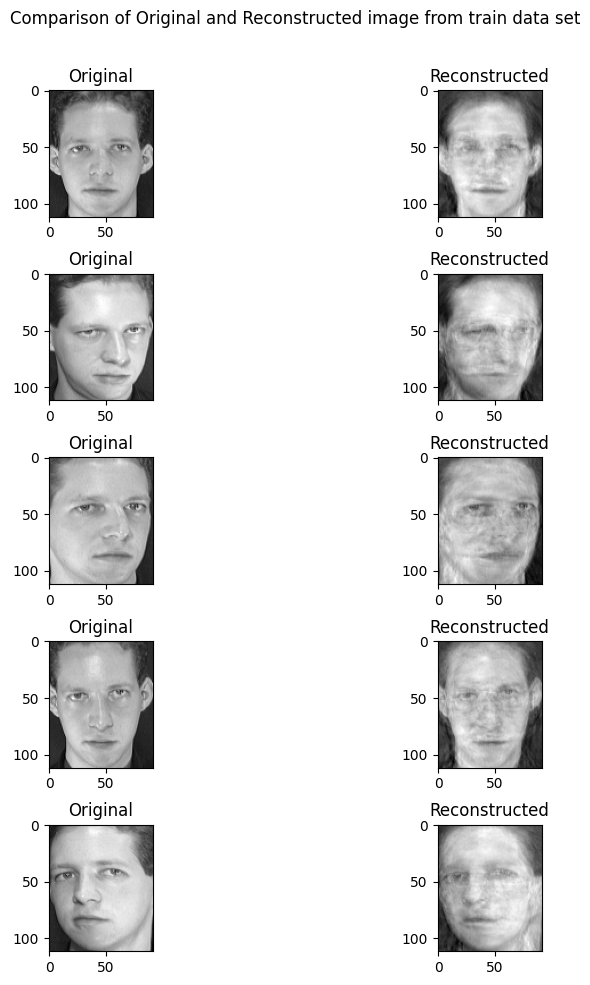

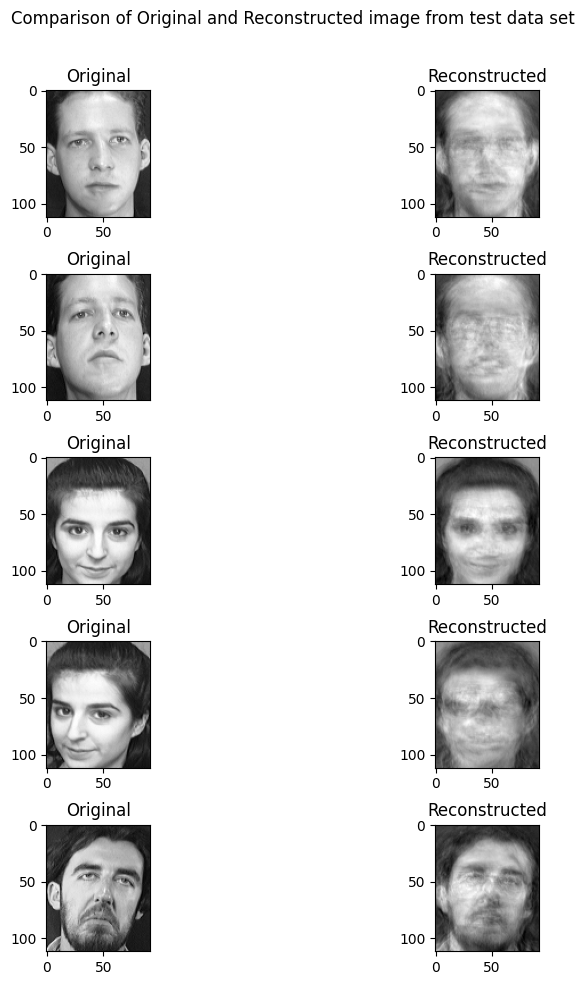

In [8]:
# 重建特征脸（训练集）五张随机照片
num_samples = 5
train_title = "Comparison of Original and Reconstructed image from train data set"
test_title = "Comparison of Original and Reconstructed image from test data set"
utils.compare_original_and_reconstructed_image(train_set, reconstructed_train_set, num_samples, train_title)
utils.compare_original_and_reconstructed_image(test_set, reconstructed_test_set, num_samples, test_title)

# 步骤4
输出降维后每个新特征向量所占的信息量占原始数据总信息量的百分比，以及所有返回特征所携带的信息量总和是原始数据的多少

In [9]:
# 输出降维后每个新特征向量所占的信息量百分比
explained_variance_ratio = pca.explained_variance_ratio_
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {ratio * 100:.2f}% of total variance")

# 计算所有返回特征所携带的信息量总和
total_variance = np.sum(explained_variance_ratio)
print(f"Total variance explained by all components: {total_variance * 100:.2f}% of total variance in the data")
print(f"Ratio of total variance explained: {total_variance * 100:.2f}%")

Component 1: 17.80% of total variance
Component 2: 12.93% of total variance
Component 3: 6.97% of total variance
Component 4: 5.57% of total variance
Component 5: 5.06% of total variance
Component 6: 3.27% of total variance
Component 7: 2.52% of total variance
Component 8: 2.41% of total variance
Component 9: 2.00% of total variance
Component 10: 1.82% of total variance
Component 11: 1.53% of total variance
Component 12: 1.37% of total variance
Component 13: 1.14% of total variance
Component 14: 1.11% of total variance
Component 15: 0.99% of total variance
Component 16: 0.95% of total variance
Component 17: 0.92% of total variance
Component 18: 0.88% of total variance
Component 19: 0.78% of total variance
Component 20: 0.72% of total variance
Component 21: 0.68% of total variance
Component 22: 0.64% of total variance
Component 23: 0.60% of total variance
Component 24: 0.56% of total variance
Component 25: 0.55% of total variance
Component 26: 0.53% of total variance
Component 27: 0.51%

# 步骤5
画出特征个数和所携带信息数的曲线图，此处特征数上限设置为150

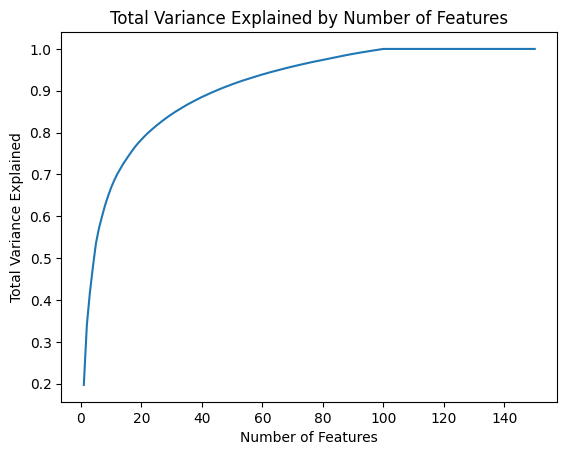

In [10]:
# 设置特征个数上限
max_features = 150

# 计算每个特征个数对应的信息量总和
total_variance_list = []
for n_components in range(1, max_features + 1):
    pca = PCA(n_components=n_components)
    pca.fit(reconstructed_train_set)
    total_variance = np.sum(pca.explained_variance_ratio_)
    total_variance_list.append(total_variance)

# 画出特征个数和所携带信息数的曲线图
plt.plot(range(1, max_features+1), total_variance_list)
plt.xlabel('Number of Features')
plt.ylabel('Total Variance Explained')
plt.title('Total Variance Explained by Number of Features')
plt.show()

# 步骤6
保留特征数为150，得到的训练集每次保留前（n=n+1，n初值为1）个特征，分别训练一个KNN分类器，KNN分类器的参数n_neighbors为3，观察并验证测试集在使用其前n个特征时KNN分类的准确率

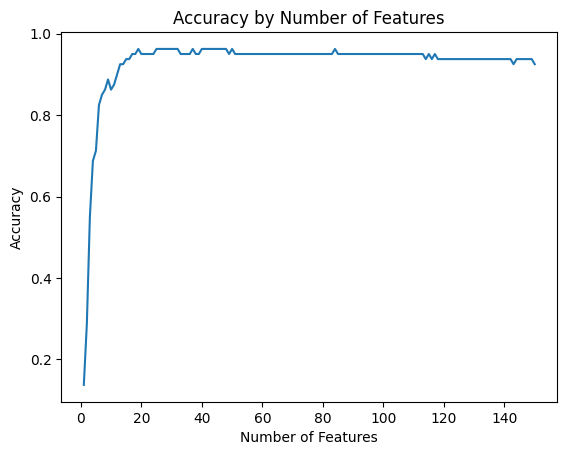

In [11]:
# 训练标签
train_labels = [num for num in range(40) for _ in range(8)]
test_labels = [num for num in range(40) for _ in range(2)]

# 初始化特征保留数和准确率的列表
n_features_list = []
accuracy_list = []

# 逐个保留特征并训练KNN分类器
for n_features in range(1, max_features+1):
    # 保留前n个特征
    pca = PCA(n_components=n_features)
    reduced_train_data = pca.fit_transform(train_set)
    reduced_test_data = pca.transform(test_set)

    # 训练KNN分类器
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(reduced_train_data, train_labels)

    # 在测试集上进行预测并计算准确率
    predictions = knn.predict(reduced_test_data)
    accuracy = accuracy_score(test_labels, predictions)

    # 添加特征保留数和准确率到列表
    n_features_list.append(n_features)
    accuracy_list.append(accuracy)

# 画出特征保留数和准确率的曲线图
plt.plot(n_features_list, accuracy_list)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy by Number of Features')
plt.show()